In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [8]:
# -----------------------------
# 1) Load Leaf River data
# -----------------------------
df = pd.read_csv("../../data/LeafRiverDaily.csv")

for col in ["Precipitation", "Temperature", "Streamflow"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Precipitation", "Temperature", "Streamflow"]).reset_index(drop=True)

P = df["Precipitation"].to_numpy(dtype=float)   # x1
T = df["Temperature"].to_numpy(dtype=float)     # x2
Q = df["Streamflow"].to_numpy(dtype=float)      # target

In [9]:
# -----------------------------
# 2) Build X = [x1, x2]
# -----------------------------
X = np.column_stack([P, T])   # shape (N, 2)
y = Q                         # shape (N,)


In [10]:
# -----------------------------
# 3) Chronological split (no shuffling)
# -----------------------------
split = int(0.8 * len(X))
X_train_raw, X_test_raw = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [11]:
# -----------------------------
# 4) Standardize inputs (important so weights learn nicely)
#    This is the "scaling + shift origin" idea on the board.
# -----------------------------
mu = X_train_raw.mean(axis=0)
sig = X_train_raw.std(axis=0)
sig[sig == 0] = 1.0

X_train = (X_train_raw - mu) / sig
X_test  = (X_test_raw  - mu) / sig

In [12]:

# -----------------------------
# 5) Whiteboard model: z = v1*ReLU(w1*x1 + w2*x2 + b) + v0
# -----------------------------
def relu(u):
    return np.maximum(0.0, u)

def relu_grad(u):
    return (u > 0.0).astype(float)


# parameters (initialized small)
rng = np.random.default_rng(0)
w = 0.01 * rng.standard_normal(2)  # [w1, w2]
b = 0.0                             # hidden bias (w10)
v1 = 0.01 * rng.standard_normal()   # output weight
v0 = 0.0                             # output bias

lr = 1e-2
epochs = 3000

In [13]:
# -----------------------------
# 6) Train with gradient descent (MSE)
# -----------------------------
N = len(X_train)
for ep in range(1, epochs + 1):
    # forward pass
    y_lin = X_train @ w + b      # y = w·x + b
    h = relu(y_lin)              # h = ReLU(y)
    z = v1 * h + v0              # z = v1*h + v0 (prediction)

    err = z - y_train
    mse = np.mean(err**2)

    # gradients
    dz = (2.0 / N) * err
    dv1 = np.sum(dz * h)
    dv0 = np.sum(dz)

    dh = dz * v1
    dy_lin = dh * relu_grad(y_lin)

    dw = X_train.T @ dy_lin
    db = np.sum(dy_lin)

    # update
    w  -= lr * dw
    b  -= lr * db
    v1 -= lr * dv1
    v0 -= lr * dv0

    # small training log
    if ep % 500 == 0:
        print(f"epoch {ep:4d} | mse={mse:.4f} | w={w} b={b:.3f} v1={v1:.3f} v0={v0:.3f}")

epoch  500 | mse=8.8690 | w=[ 0.21026084 -0.20946358] b=0.143 v1=0.330 v0=1.365
epoch 1000 | mse=8.7122 | w=[ 0.26992021 -0.63879855] b=0.374 v1=0.788 v0=1.004
epoch 1500 | mse=8.7082 | w=[ 0.22784751 -0.68267489] b=0.424 v1=0.835 v0=0.925
epoch 2000 | mse=8.7081 | w=[ 0.22503205 -0.6801136 ] b=0.439 v1=0.840 v0=0.911
epoch 2500 | mse=8.7080 | w=[ 0.22350526 -0.67010365] b=0.455 v1=0.840 v0=0.905
epoch 3000 | mse=8.7077 | w=[ 0.2228061  -0.65250479] b=0.482 v1=0.841 v0=0.894


In [14]:
# -----------------------------
# 7) Predict function
# -----------------------------
def predict(X):
    y_lin = X @ w + b
    h = relu(y_lin)
    z = v1 * h + v0
    return z


yhat_train = predict(X_train)
yhat_test  = predict(X_test)

In [15]:
# -----------------------------
# 8) Metrics
# -----------------------------
def metrics(ytrue, ypred, name):
    r2 = r2_score(ytrue, ypred)
    mae = mean_absolute_error(ytrue, ypred)
    rmse = np.sqrt(mean_squared_error(ytrue, ypred))
    print(f"\n{name}")
    print(f"  R²   = {r2:.3f}")
    print(f"  MAE  = {mae:.3f}")
    print(f"  RMSE = {rmse:.3f}")

metrics(y_train, yhat_train, "TRAIN")
metrics(y_test,  yhat_test,  "TEST")


TRAIN
  R²   = 0.026
  MAE  = 1.439
  RMSE = 2.951

TEST
  R²   = 0.034
  MAE  = 1.338
  RMSE = 2.469


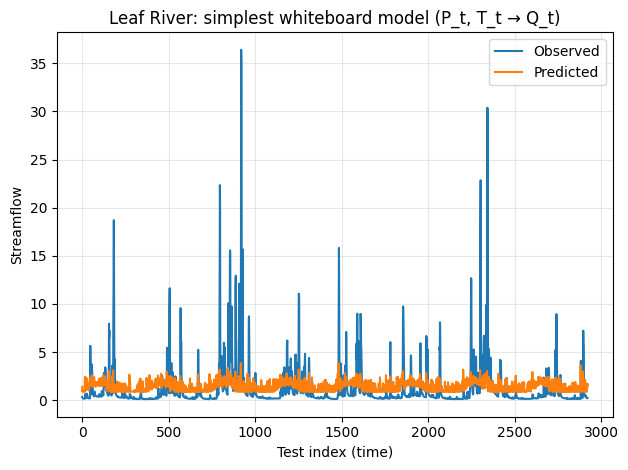

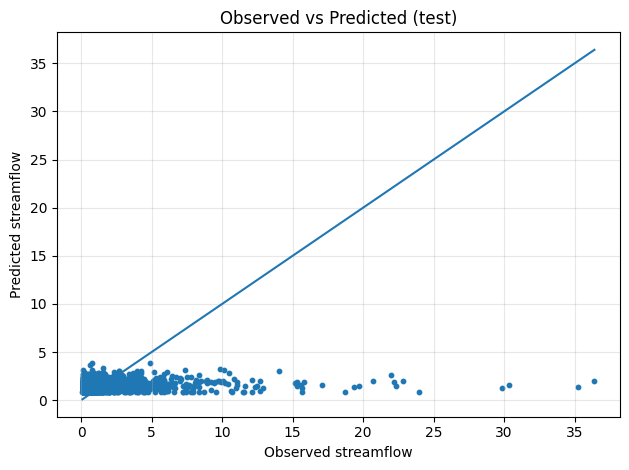


ReLU active on test set: 73.1% of days


In [16]:

# -----------------------------
# 9) Plots to understand what’s happening
# -----------------------------
# (A) time series on test set
plt.figure()
plt.plot(y_test, label="Observed")
plt.plot(yhat_test, label="Predicted")
plt.title("Leaf River: simplest whiteboard model (P_t, T_t → Q_t)")
plt.xlabel("Test index (time)")
plt.ylabel("Streamflow")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (B) observed vs predicted scatter
plt.figure()
plt.scatter(y_test, yhat_test, s=10)
mn = min(y_test.min(), yhat_test.min())
mx = max(y_test.max(), yhat_test.max())
plt.plot([mn, mx], [mn, mx])
plt.title("Observed vs Predicted (test)")
plt.xlabel("Observed streamflow")
plt.ylabel("Predicted streamflow")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (C) visualize the ReLU gate: how many samples are active?
gate_test = (X_test @ w + b) > 0
print(f"\nReLU active on test set: {gate_test.mean()*100:.1f}% of days")